# Book Recommendation System

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/FastAI/Book%20Recommendation%20System.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/FastAI/Book%20Recommendation%20System.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [1]:
from fastai.collab import *

In [2]:
path = Path('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k')
path.ls()

[PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/books.csv'),
 PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/book_tags.csv'),
 PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/ratings.csv'),
 PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/sample_book.xml'),
 PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/tags.csv'),
 PosixPath('/media/gilbert/948A92E98A92C760/Local_Programming/Datasets/Other/goodbooks-10k/to_read.csv')]

In [3]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [5]:
data.show_batch()

user_id,book_id,target
40234,39,3.0
23264,77,4.0
41953,2208,4.0
36431,2710,5.0
15299,6109,5.0


In [6]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

## EmbeddingDotBias Model

In [7]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [8]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [1, 40]              2,137,000  True      
______________________________________________________________________
Embedding            [1, 40]              400,040    True      
______________________________________________________________________
Embedding            [1, 1]               53,425     True      
______________________________________________________________________
Embedding            [1, 1]               10,001     True      
______________________________________________________________________

Total params: 2,600,466
Total trainable params: 2,600,466
Total non-trainable params: 0



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


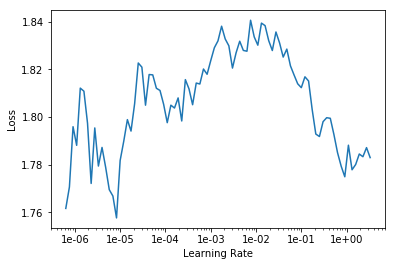

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.114507,1.126222,10:22
1,0.946091,0.936259,10:24
2,0.938270,0.924418,10:28
3,0.920206,0.917331,10:26
4,0.917690,0.915466,10:33


In [11]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

In [12]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


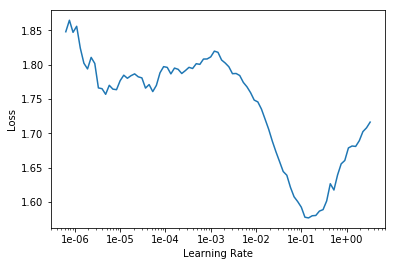

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.778428,0.792107,13:26
1,0.782044,0.799858,13:27
2,0.777911,0.785180,13:18
3,0.750171,0.742878,13:01
4,0.676612,0.705698,13:15


In [15]:
learn.save('goodbooks-nn-1')

## Interpretation

In [16]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

In [17]:
books = pd.read_csv(path/'books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [18]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['1', '2', '4', '3', '5', '17', '20', '18', '23', '7'], dtype='<U21')

In [20]:
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['book_id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name

array(['The Hunger Games (The Hunger Games, #1)', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
       'To Kill a Mockingbird', 'Twilight (Twilight, #1)', ..., 'Lover Eternal (Black Dagger Brotherhood, #2)',
       'The Sirens of Titan', 'Cryptonomicon', 'Animal, Vegetable, Miracle: A Year of Food Life'], dtype='<U151')

## Book Bias

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53425, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53425, 1)
  (i_bias): Embedding(10001, 1)
)

In [22]:
book_bias = learn.bias(top_books, is_item=True)

In [23]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

In [24]:
item0 = lambda o:o[0]

In [25]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.1689),
  'Fifty Shades of Grey (Fifty Shades, #1)',
  3.0924391506991196),
 (tensor(-0.1190), 'Twilight (Twilight, #1)', 3.214340558738409),
 (tensor(-0.1163), 'New Moon (Twilight, #2)', 3.217359967051071),
 (tensor(-0.0487), 'Breaking Dawn (Twilight, #4)', 3.354924202268631),
 (tensor(-0.0296), 'Eclipse (Twilight, #3)', 3.3775467775467773),
 (tensor(-0.0202), 'The Nanny Diaries (Nanny, #1)', 3.2395676973881717),
 (tensor(-0.0199), 'Eat, Pray, Love', 3.260114140773621),
 (tensor(0.0003), 'The Scarlet Letter', 3.3282900743445936),
 (tensor(0.0006), 'The Secret (The Secret, #1)', 3.1555555555555554),
 (tensor(0.0080), 'The Red Badge of Courage', 3.1833962264150943),
 (tensor(0.0117), 'Digital Fortress', 3.332096015837664),
 (tensor(0.0173),
  'The Short Second Life of Bree Tanner: An Eclipse Novella (Twilight, #3.5)',
  3.3007730147575542),
 (tensor(0.0177), 'Fifty Shades Freed (Fifty Shades, #3)', 3.44468339307049),
 (tensor(0.0189), 'Evermore (The Immortals, #1)', 3.3646706

In [26]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.9103),
  'Harry Potter and the Deathly Hallows (Harry Potter, #7)',
  4.525940930475692),
 (tensor(0.8232),
  'Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
  4.443339301107353),
 (tensor(0.8172),
  'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
  4.430780132706307),
 (tensor(0.7909),
  'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
  4.418732261116367),
 (tensor(0.7544), 'The Help', 4.382886776145203),
 (tensor(0.7382), 'The Nightingale', 4.467266775777414),
 (tensor(0.7329), 'To Kill a Mockingbird', 4.3293692372171),
 (tensor(0.7193),
  'A Storm of Swords (A Song of Ice and Fire, #3)',
  4.420554753888087),
 (tensor(0.7182),
  "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
  4.351350114416476),
 (tensor(0.7140),
  'Unbroken: A World War II Story of Survival, Resilience, and Redemption',
  4.439370766877867),
 (tensor(0.7133),
  'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
  4.358697076943243),
 (tenso

In [27]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [28]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [29]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [30]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.4788), 'The Dinner'),
 (tensor(1.4301), 'Fifty Shades of Grey (Fifty Shades, #1)'),
 (tensor(1.4247), 'Twilight (Twilight, #1)'),
 (tensor(1.3591), 'Go Set a Watchman'),
 (tensor(1.3236), 'The Secret (The Secret, #1)'),
 (tensor(1.3030),
  'The Short Second Life of Bree Tanner: An Eclipse Novella (Twilight, #3.5)'),
 (tensor(1.2869), 'The Tenth Circle'),
 (tensor(1.2257), 'Reached (Matched, #3)'),
 (tensor(1.2210), "The Pilot's Wife"),
 (tensor(1.2094), 'Luckiest Girl Alive')]

In [31]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-1.7420), 'The Return of the King (The Lord of the Rings, #3)'),
 (tensor(-1.6044), 'The Lord of the Rings (The Lord of the Rings, #1-3)'),
 (tensor(-1.6003), 'The Two Towers (The Lord of the Rings, #2)'),
 (tensor(-1.5340), 'Harry Potter and the Deathly Hallows (Harry Potter, #7)'),
 (tensor(-1.5058), 'The Fellowship of the Ring (The Lord of the Rings, #1)'),
 (tensor(-1.4882), 'Where the Sidewalk Ends'),
 (tensor(-1.4786), 'A Storm of Swords (A Song of Ice and Fire, #3)'),
 (tensor(-1.4444), 'The Name of the Wind (The Kingkiller Chronicle, #1)'),
 (tensor(-1.4062), 'To Kill a Mockingbird'),
 (tensor(-1.3408), 'The Giving Tree')]

In [32]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [33]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.8752), 'Divergent (Divergent, #1)'),
 (tensor(1.8483),
  'Harry Potter and the Chamber of Secrets (Harry Potter, #2)'),
 (tensor(1.8426), 'Harry Potter and the Deathly Hallows (Harry Potter, #7)'),
 (tensor(1.8326), 'The Hunger Games (The Hunger Games, #1)'),
 (tensor(1.8048), 'Catching Fire (The Hunger Games, #2)'),
 (tensor(1.7736), 'Harry Potter and the Goblet of Fire (Harry Potter, #4)'),
 (tensor(1.7620), 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)'),
 (tensor(1.7466),
  'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)'),
 (tensor(1.7377), "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"),
 (tensor(1.7170),
  'Harry Potter and the Order of the Phoenix (Harry Potter, #5)')]

In [34]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-1.3292), 'Animal Farm'),
 (tensor(-1.2168), '1984'),
 (tensor(-1.1647), 'Lord of the Flies'),
 (tensor(-1.0308), 'Heart of Darkness'),
 (tensor(-0.9961), 'The Metamorphosis'),
 (tensor(-0.9312), 'Moby-Dick or, The Whale'),
 (tensor(-0.9209), 'Hamlet'),
 (tensor(-0.9109), 'Macbeth'),
 (tensor(-0.8967), 'The Catcher in the Rye'),
 (tensor(-0.8962), 'The Grapes of Wrath')]

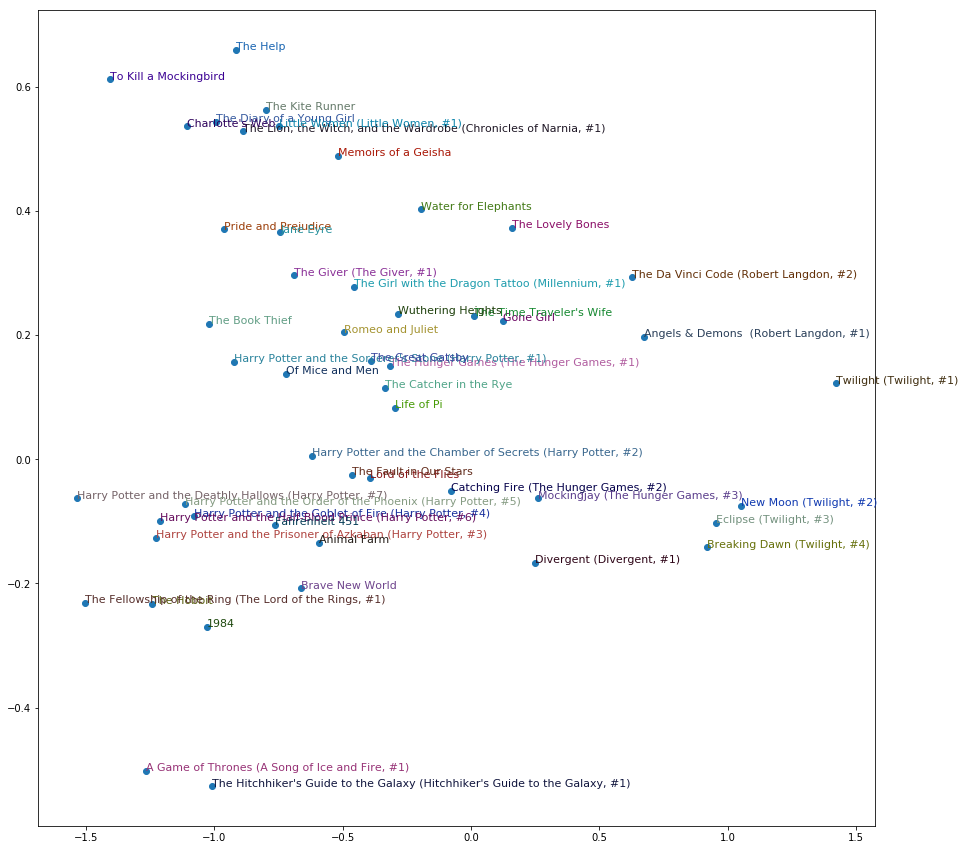

In [35]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()